In [17]:
import sys
# !{sys.executable} -m pip install quandl
# !{sys.executable} -m pip install fredapi

from fredapi import Fred
import quandl
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
from datetime import date
from datetime import timedelta
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor

# api_Key="your FRED api key here"

# quandl.ApiConfig.api_key="your quandl api key here"

# fred = Fred(api_key=api_Key)

In [47]:
## Pickle Shortcut

wilshire=pd.read_pickle()
shillerDataMarginData=pd.read_pickle()

Pull the FRED data

In [ ]:
## Read FRED metadata file from disk (available to download at Quandl). We need all the series codes on FRED.
#  Reformat from_date and to_date cells in FRED metadata file in excel to show 4 year date.
## *Below Problem still exists, but is not fatal*
#  In the Quandl FRED metadata document some series that end in 1975 are encoded as ending in 2075, 
#  and others that end in 1948 are encoded as ending in 2048.


fredMetadata=pd.read_csv('location of quandl FRED meta file on your disk here',low_memory=False,encoding='latin-1')
fredMetadata['from_date']=pd.to_datetime(fredMetadata['from_date'],yearfirst=False)    
fredMetadata['to_date']=pd.to_datetime(fredMetadata['to_date'],yearfirst=False)   

In [ ]:
wilshire=fred.get_series_first_release('WILL5000PR')
wilshire=pd.DataFrame(wilshire)
wilshire=wilshire.fillna(method='pad')
wilshire=wilshire.resample('D').fillna(method='ffill')
wilshire.rename(columns={'value': 'Wilshire5000'}, inplace=True)
wilshire=wilshire.iloc[1:len(wilshire),]

In [ ]:
## Select all FRED data series that cover period from 1970-12-31 to one year prior to present (daily, quarterly, or annual frequencies)

delta = timedelta(days=366)
latest = date.today() - delta 

start_date='1970-12-31'                 # Wilshire 5000 Series Starts here
end_date=str(latest)                    # Accept all data series that end as early as 1 year ago

mask=(fredMetadata['from_date'] < start_date) & (fredMetadata['to_date'] > end_date)  ## Less than means later than WTF

features=fredMetadata.loc[mask]         # All data series with start date and end date covering Wilshire series

codes=features.code

codelst=[]
for code in codes:
    codelst.append(code)

len(codelst)   # Print the number of data series on FRED matching the above mask criteria. I'm getting 7107                  

In [ ]:
## Function to get a series/feature from FRED

def getSeries(code):
    series=quandl.get("FRED/" + code)
    return series

In [ ]:
## Create Counter to iterate over code list

codeCount=range(0,len(codelst),1)

counter=[]
for i in codeCount:
    counter.append(i)

In [ ]:
## Iterate over the getSeries function with the code list and append each series to the dataframe 'wilshire'
#  Also add column headers

for i in counter:
    try:
        wilshire[codelst[i]]=getSeries(codelst[i]) 
        if i%100==0:
            print(i)         # Change to print every 100 pulls instead of every pull 'Completed: Pull '+ i
    except Exception:
        continue

Pulling FRED Data Completed

In [48]:
## Clean and Add Margin Interest Data and Shiller Data

wilshire=wilshire.join(shillerDataMarginData,how='outer')
wilshire=wilshire['1971-1-1':date.today()]

## Prepare and Clean the Dataframe 'wilshire' with target and features

wilshireFfill=wilshire.fillna(method="ffill",limit=365)            ## Forward Fill a maximum of 365 days for annual frequency data
wilshire0=wilshireFfill.fillna(0,inplace=False)                    ## If there are any NaN left, then replace them with 0

wilshire=wilshire0.loc[:, (wilshire0==0).any(axis=0)==False]  ## Remove all Columns with any 0s after 1970-12-31

In [46]:
# pd.DataFrame.to_pickle('path')   # Store Clean Frame with Pickle

In [84]:
# Define Graphing Function to Visualize Train Predictions and 

def graph(clf):

    ## Make predictions for both train and test for visualization

    # Normalize wilshire by TRAIN data mean and standard deviation

    wilshireNormal1=(wilshire-mean)/std
    wilshireNormal=wilshireNormal1.dropna(axis='columns')

    # Put wilshireNormal into an array

    predictionArray=np.array(wilshireNormal)

    trainAndTestPredictions=clf.predict(predictionArray)
    trainAndTestPredictions=trainAndTestPredictions.reshape(-1,1)
    trainAndTestPredictionsFlattened=list(trainAndTestPredictions.flatten())


    #  Make a dataframe with predictions and targets

    index=wilshire.index.values    
    predictionsDF=pd.DataFrame(trainAndTestPredictionsFlattened,index=index+pd.Timedelta(weeks=7*52))  ##   Alternatively, +pd.Timedelta(weeks=7*52)) 
    totalTargetDF=pd.DataFrame(wilshire['Wilshire5000']) 

    predictionsWithTotalTarget=totalTargetDF.join(predictionsDF, how='outer') 


    # Create Labels and Signal Ratio

    predictionsWithTotalTarget.columns=['Wilshire5000','Model Prediction for 7 Year Hence Value']
#     predictionsWithTotalTarget['Ratio']=predictionsWithTotalTarget['Model Prediction for 7 Year Hence Value']/predictionsWithTotalTarget['Wilshire5000']


    # Create Graph

    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    ax1.plot(predictionsWithTotalTarget.index, predictionsWithTotalTarget['Model Prediction for 7 Year Hence Value'])
    ax1.plot(predictionsWithTotalTarget.index, predictionsWithTotalTarget['Wilshire5000'])
    ax1.set_ylabel('Wilshire 5000')
    plt.yscale('log')


#     ax2 = ax1.twinx()
#     ax2.plot(predictionsWithTotalTarget.index, predictionsWithTotalTarget['Ratio'], 'r-')
#     ax2.set_ylabel('Ratio', color='r')

#     for tl in ax2.get_yticklabels():
#         tl.set_color('r')

    handles, labels = ax1.get_legend_handles_labels()
#     handles2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(handles,labels)

    ax1.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.xticks(np.arange(min(predictionsWithTotalTarget.index), max(predictionsWithTotalTarget.index)+timedelta(days=365), timedelta(days=730)))

    plt.rcParams["figure.figsize"] = (20,5)
    return plt.show()

In [103]:
## Train the Network up to 3-24-2000 Peak

train=wilshire['1971-1-1':'1993-3-24']  
test=wilshire['1993-3-24':date.today()] 

# Normalize Train and Test Sets using only train means and standard deviations

mean=train.mean(axis=0)
std=train.std(axis=0)

train=(train-mean)/std
test=(test-mean)/std


What is the shape of the train set: (8119, 5664)
What is the shape of the test set: (9305, 5664)
How many NaNs in Train Set? 8119
How many NaNs in Test Set? 8119
What is the shape of the train set: (8119, 5663)
What is the shape of the test set: (9305, 5663)
How many NaNs in Train Set? 0
How many NaNs in Test Set? 0
(8119,)
Iteration 1, loss = 5451117.00214901
Validation score: 0.873457
Iteration 2, loss = 181811.79709311
Validation score: 0.988316
Iteration 3, loss = 39763.57942787
Validation score: 0.995060
Iteration 4, loss = 21315.78859936
Validation score: 0.995813
Iteration 5, loss = 17525.53081702
Validation score: 0.996777
Iteration 6, loss = 15577.90091774
Validation score: 0.996998
Iteration 7, loss = 14154.52799773
Validation score: 0.997498
Iteration 8, loss = 12943.92419333
Validation score: 0.997624
Iteration 9, loss = 12139.57066648
Validation score: 0.997781
Iteration 10, loss = 11620.50251918
Validation score: 0.997779
Iteration 11, loss = 10902.69397784
Validation sco

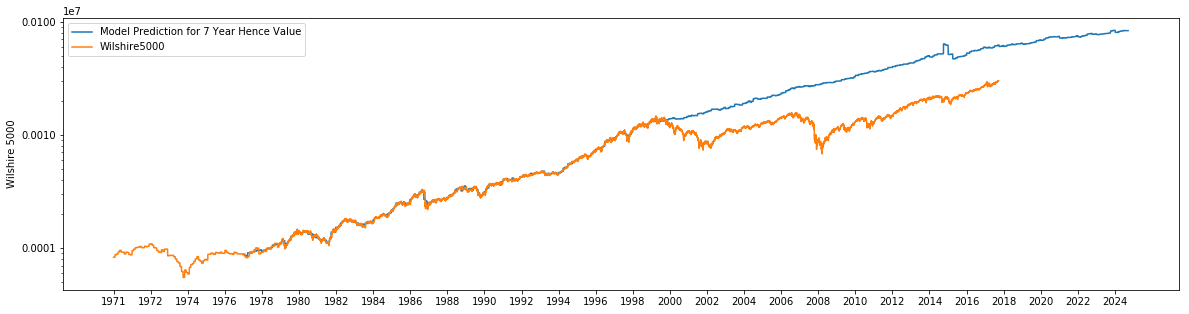

In [104]:
# Find the Train Target

indicesOfTrain=train.index
indicesOfTrainTarget=indicesOfTrain + pd.Timedelta(weeks=7*52)

trainTargetRows=[]
for i in indicesOfTrainTarget:
     trainTargetRows.append(wilshire.loc[i])               

trainTargetRows=pd.DataFrame(trainTargetRows,index=indicesOfTrainTarget)
trainTarget=trainTargetRows['Wilshire5000']   ## Select Target from Rows of Target Dates
trainTarget=pd.DataFrame(trainTarget,index=trainTargetRows.index)

trainTarget=np.ravel(trainTarget,order='c')

print(trainTarget.shape)

# Make the Model
# The number of Nodes in Each Hidden Layer is Equal to 1/3 of the Features being Learned

n=round( len(wilshire.columns)/3 )   

#### Make the Classifier

clf=MLPRegressor(solver='adam',
                 learning_rate='constant',
                 learning_rate_init=.0001,
                 warm_start=True,
                 verbose=True, 
                 early_stopping=True, 
                 validation_fraction=0.25, 
                 max_iter=20,
                 hidden_layer_sizes=(n,n,n,n,n,n,n,n,n,n,n), 
                 alpha=.00001)

clf.fit(train,trainTarget)


graph(clf)

Optimize the base estimator up to 2000
Lowest Loss: 
Highest Validation Score: .998187         

Notes:

In [105]:
## Train the Network up to 2007-10-9 Peak

train=wilshire['1971-1-1':'2000-10-9']  
test=wilshire['2000-10-9':date.today()] 

# Normalize Train and Test Sets using only train means and standard deviations

mean=train.mean(axis=0)
std=train.std(axis=0)

train=(train-mean)/std
test=(test-mean)/std


What is the shape of the train set: (10875, 5664)
What is the shape of the test set: (6549, 5664)
How many NaNs in Train Set? 10875
How many NaNs in Test Set? 10875
What is the shape of the train set: (10875, 5663)
What is the shape of the test set: (6549, 5663)
How many NaNs in Train Set? 0
How many NaNs in Test Set? 0
(10875,)
Iteration 1, loss = 9243659.54501886
Validation score: 0.937902
Iteration 2, loss = 199063.40986020
Validation score: 0.990741
Iteration 3, loss = 66719.09117138
Validation score: 0.994958
Iteration 4, loss = 40028.97715732
Validation score: 0.996248
Iteration 5, loss = 31296.70075095
Validation score: 0.995970
Iteration 6, loss = 25739.75184088
Validation score: 0.997397
Iteration 7, loss = 23709.50865150
Validation score: 0.997649
Iteration 8, loss = 24401.88898592
Validation score: 0.997474
Iteration 9, loss = 21075.17566448
Validation score: 0.997760
Iteration 10, loss = 19416.71702979
Validation score: 0.997781
Iteration 11, loss = 21586.84581629
Validatio

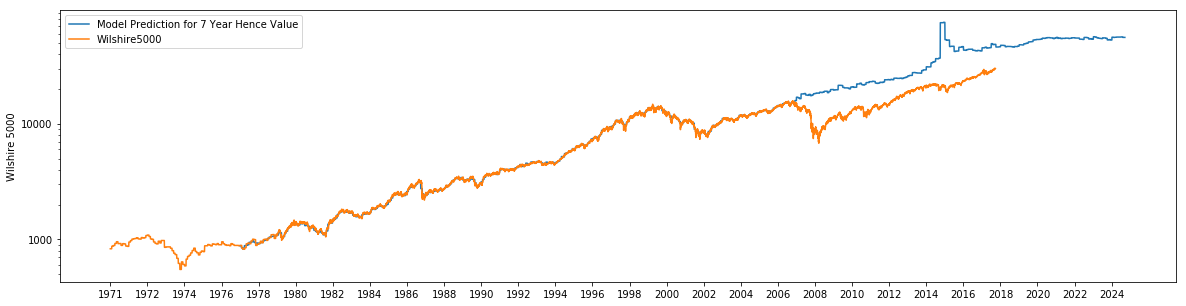

In [106]:
# Find the Train Target

indicesOfTrain=train.index
indicesOfTrainTarget=indicesOfTrain + pd.Timedelta(weeks=7*52)

trainTargetRows=[]
for i in indicesOfTrainTarget:
     trainTargetRows.append(wilshire.loc[i])               

trainTargetRows=pd.DataFrame(trainTargetRows,index=indicesOfTrainTarget)
trainTarget=trainTargetRows['Wilshire5000']   ## Select Target from Rows of Target Dates
trainTarget=pd.DataFrame(trainTarget,index=trainTargetRows.index)

trainTarget=np.ravel(trainTarget,order='c')

print(trainTarget.shape)

# Make the Model
# The number of Nodes in Each Hidden Layer is Equal to 1/3 of the Features being Learned

n=round( len(wilshire.columns)/3 )   

#### Make the Classifier

clf=MLPRegressor(solver='adam',
                 learning_rate='constant',
                 learning_rate_init=.0001,
                 warm_start=True,
                 verbose=True, 
                 early_stopping=True, 
                 validation_fraction=0.25, 
                 max_iter=20,
                 hidden_layer_sizes=(n,n,n,n,n,n,n,n,n,n,n), 
                 alpha=.00001)

clf.fit(train,trainTarget)

graph(clf)

Optimizing the base estimator up to 2007
Lowest Loss: .0023,
Highest Validation: .9958,.9965,.9980

Notes: 

In [107]:
## Train the Network up to Present 

train=wilshire['1971-1-1':'2011-9-16']  
test=wilshire['2011-9-16':date.today()] 

# Normalize Train and Test Sets using only train means and standard deviations

mean=train.mean(axis=0)
std=train.std(axis=0)

train=(train-mean)/std
test=(test-mean)/std


What is the shape of the train set: (14869, 5664)
What is the shape of the test set: (2555, 5664)
How many NaNs in Train Set? 14869
How many NaNs in Test Set? 14869
What is the shape of the train set: (14869, 5663)
What is the shape of the test set: (2555, 5663)
How many NaNs in Train Set? 0
How many NaNs in Test Set? 0
(14869,)
Iteration 1, loss = 18190591.29508515
Validation score: 0.980130
Iteration 2, loss = 258621.78211820
Validation score: 0.994457
Iteration 3, loss = 100010.42364048
Validation score: 0.996295
Iteration 4, loss = 66191.29224413
Validation score: 0.997342
Iteration 5, loss = 52006.01741582
Validation score: 0.997905
Iteration 6, loss = 46210.28747378
Validation score: 0.998184
Iteration 7, loss = 42478.51120733
Validation score: 0.997872
Iteration 8, loss = 41395.75249127
Validation score: 0.998373
Iteration 9, loss = 40313.96194465
Validation score: 0.998066
Iteration 10, loss = 38234.70973389
Validation score: 0.998448
Iteration 11, loss = 38412.55783151
Validat

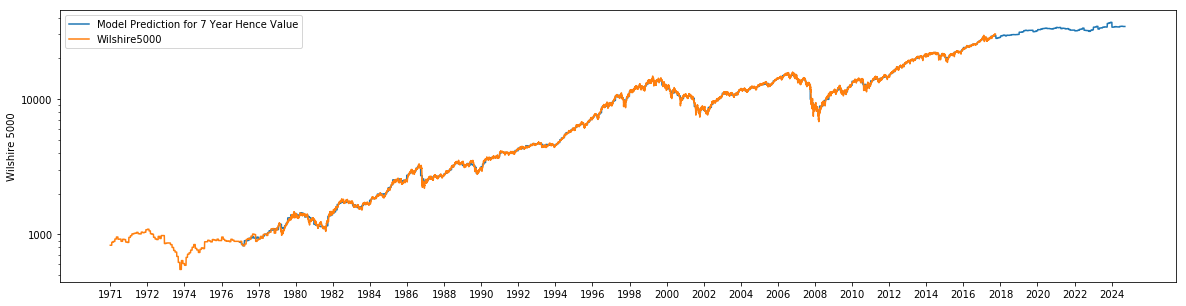

In [108]:
# Find the Train Target

indicesOfTrain=train.index
indicesOfTrainTarget=indicesOfTrain + pd.Timedelta(weeks=7*52)

trainTargetRows=[]
for i in indicesOfTrainTarget:
     trainTargetRows.append(wilshire.loc[i])               

trainTargetRows=pd.DataFrame(trainTargetRows,index=indicesOfTrainTarget)
trainTarget=trainTargetRows['Wilshire5000']   ## Select Target from Rows of Target Dates
trainTarget=pd.DataFrame(trainTarget,index=trainTargetRows.index)

trainTarget=np.ravel(trainTarget,order='c')

print(trainTarget.shape)

# Make the Model
# The number of Nodes in Each Hidden Layer is Equal to 1/3 of the Features being Learned

n=round( len(wilshire.columns)/3 )   

#### Make the Classifier

clf=MLPRegressor(solver='adam',
                 learning_rate='constant',
                 learning_rate_init=.0001,
                 warm_start=True,
                 verbose=True, 
                 early_stopping=True, 
                 validation_fraction=0.25, 
                 max_iter=20,
                 hidden_layer_sizes=(n,n,n,n,n,n,n,n,n,n,n), 
                 alpha=.00001)

clf.fit(train,trainTarget)

graph(clf)

Optimize the base estimator up to 2018
Lowest Loss: 41,179
Highest Validation: .998453

Notes: 

 BAGGING on RANDOM PATCHES: or training base estimators on subsets
 of training samples and training features and averaging their predictions. 

In [109]:
## Train the Network on Random Patches up to 3-24-2000 Peak

train=wilshire['1971-1-1':'1993-3-24']  
test=wilshire['1993-3-24':date.today()] 

# Normalize Train and Test Sets using only train means and standard deviations

mean=train.mean(axis=0)
std=train.std(axis=0)

train=(train-mean)/std
test=(test-mean)/std

What is the shape of the train set: (8119, 5664)
What is the shape of the test set: (9305, 5664)
How many NaNs in Train Set? 8119
How many NaNs in Test Set? 8119
What is the shape of the train set: (8119, 5663)
What is the shape of the test set: (9305, 5663)
How many NaNs in Train Set? 0
How many NaNs in Test Set? 0
(8119,)
Iteration 1, loss = 12255106.02204552
Validation score: -1.554417
Iteration 2, loss = 12199541.50966326
Validation score: -1.495485
Iteration 3, loss = 11600502.52249811
Validation score: -1.034848
Iteration 4, loss = 7851134.20951782
Validation score: 0.628487
Iteration 5, loss = 2945110.99797527
Validation score: 0.821505
Iteration 6, loss = 1404030.88298872
Validation score: 0.592077
Iteration 7, loss = 1187436.65386790
Validation score: 0.875061
Iteration 8, loss = 1258452.99720858
Validation score: 0.946773
Iteration 9, loss = 596926.26532494
Validation score: 0.734719
Iteration 10, loss = 894309.72808241
Validation score: 0.958976
Iteration 11, loss = 707042.7

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 13894629.90076187
Validation score: -1.722505
Iteration 2, loss = 13847767.24395641
Validation score: -1.673651
Iteration 3, loss = 13400444.01580895
Validation score: -1.238651
Iteration 4, loss = 9669431.72299216
Validation score: 0.463332
Iteration 5, loss = 3859562.88710965
Validation score: 0.811623
Iteration 6, loss = 1012923.14326437
Validation score: 0.679355
Iteration 7, loss = 1363588.55171158
Validation score: 0.913626
Iteration 8, loss = 863525.79869829
Validation score: 0.903285
Iteration 9, loss = 482384.26717466
Validation score: 0.840069
Iteration 10, loss = 827542.13283975
Validation score: 0.958009
Iteration 11, loss = 402038.43185729
Validation score: 0.920217
Iteration 12, loss = 248517.48301144
Validation score: 0.940894
Iteration 13, loss = 356231.57242908
Validation score: 0.972966
Iteration 14, loss = 193485.92756614
Validation score: 0.966319
Iteration 15, loss = 135984.05479148
Validation score: 0.973427
Iteration 16, loss = 121585.96127252

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 12535211.81275473
Validation score: -1.523049
Iteration 2, loss = 12485665.54410317
Validation score: -1.466553
Iteration 3, loss = 11965110.93617389
Validation score: -1.028916
Iteration 4, loss = 8311111.93009176
Validation score: 0.469605
Iteration 5, loss = 3582989.98925614
Validation score: 0.842107
Iteration 6, loss = 1312435.46055637
Validation score: 0.620722
Iteration 7, loss = 1285906.78053116
Validation score: 0.858147
Iteration 8, loss = 967228.80954224
Validation score: 0.886768
Iteration 9, loss = 503278.58060967
Validation score: 0.841843
Iteration 10, loss = 556840.89856339
Validation score: 0.926516
Iteration 11, loss = 359867.29013697
Validation score: 0.956340
Iteration 12, loss = 166296.63498233
Validation score: 0.962116
Iteration 13, loss = 152156.76102721
Validation score: 0.959570
Iteration 14, loss = 154346.48509076
Validation score: 0.979089
Iteration 15, loss = 85940.07765764
Validation score: 0.984388
Iteration 16, loss = 69362.28742814
V

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 12548940.39698712
Validation score: -1.751226
Iteration 2, loss = 12493988.04526753
Validation score: -1.689245
Iteration 3, loss = 11975725.41069843
Validation score: -1.175414
Iteration 4, loss = 8208230.42633103
Validation score: 0.543229
Iteration 5, loss = 2788347.64393761
Validation score: 0.871038
Iteration 6, loss = 867666.09334215
Validation score: 0.871120
Iteration 7, loss = 534810.68717271
Validation score: 0.807470
Iteration 8, loss = 526673.25629298
Validation score: 0.890334
Iteration 9, loss = 471506.25263332
Validation score: 0.927554
Iteration 10, loss = 408958.43274179
Validation score: 0.955504
Iteration 11, loss = 261032.80178532
Validation score: 0.930122
Iteration 12, loss = 258836.75974929
Validation score: 0.946008
Iteration 13, loss = 240947.27698108
Validation score: 0.975321
Iteration 14, loss = 147724.31155582
Validation score: 0.973530
Iteration 15, loss = 97456.88644794
Validation score: 0.969845
Iteration 16, loss = 82296.35120643
Val

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 12179319.29152325
Validation score: -1.573191
Iteration 2, loss = 12128703.74443043
Validation score: -1.511058
Iteration 3, loss = 11557332.35930605
Validation score: -0.992647
Iteration 4, loss = 7543759.97842576
Validation score: 0.323915
Iteration 5, loss = 3493343.05943819
Validation score: 0.810184
Iteration 6, loss = 1037165.78047185
Validation score: 0.600179
Iteration 7, loss = 1495910.77697303
Validation score: 0.901707
Iteration 8, loss = 522251.57430884
Validation score: 0.856852
Iteration 9, loss = 458715.66135146
Validation score: 0.892310
Iteration 10, loss = 365939.98694525
Validation score: 0.945925
Iteration 11, loss = 192192.65597225
Validation score: 0.956940
Iteration 12, loss = 129732.94126355
Validation score: 0.962756
Iteration 13, loss = 131131.76976602
Validation score: 0.966840
Iteration 14, loss = 96358.08367453
Validation score: 0.977448
Iteration 15, loss = 67262.65902993
Validation score: 0.980639
Iteration 16, loss = 75689.67590546
Va

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 12820406.44917324
Validation score: -1.548930
Iteration 2, loss = 12775813.47901419
Validation score: -1.504524
Iteration 3, loss = 12347305.80548584
Validation score: -1.097924
Iteration 4, loss = 9008628.12012246
Validation score: 0.565320
Iteration 5, loss = 3337968.32789817
Validation score: 0.852069
Iteration 6, loss = 1103075.84547286
Validation score: 0.804292
Iteration 7, loss = 602112.22168428
Validation score: 0.720031
Iteration 8, loss = 1002157.89864124
Validation score: 0.877318
Iteration 9, loss = 781233.36500302
Validation score: 0.875556
Iteration 10, loss = 399180.44587598
Validation score: 0.913575
Iteration 11, loss = 299162.54526810
Validation score: 0.954715
Iteration 12, loss = 216502.32845642
Validation score: 0.978384
Iteration 13, loss = 124842.86328888
Validation score: 0.974960
Iteration 14, loss = 106198.38296537
Validation score: 0.978748
Iteration 15, loss = 93397.22276947
Validation score: 0.982288
Iteration 16, loss = 103006.98368789


/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 12632772.04025123
Validation score: -1.334293
Iteration 2, loss = 12578614.24197219
Validation score: -1.281601
Iteration 3, loss = 12015069.59337789
Validation score: -0.825100
Iteration 4, loss = 8024249.81433091
Validation score: 0.521626
Iteration 5, loss = 2600050.75021208
Validation score: 0.810846
Iteration 6, loss = 1316173.82821011
Validation score: 0.818334
Iteration 7, loss = 589746.28675625
Validation score: 0.878570
Iteration 8, loss = 428297.02957570
Validation score: 0.871888
Iteration 9, loss = 472730.20004575
Validation score: 0.952674
Iteration 10, loss = 229476.25193831
Validation score: 0.964365
Iteration 11, loss = 147882.58384749
Validation score: 0.963227
Iteration 12, loss = 126085.76569725
Validation score: 0.975441
Iteration 13, loss = 114400.50396889
Validation score: 0.978923
Iteration 14, loss = 88161.51546342
Validation score: 0.984354
Iteration 15, loss = 63045.55322848
Validation score: 0.986901
Iteration 16, loss = 60383.23046743
Val

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 13302248.00224364
Validation score: -1.413674
Iteration 2, loss = 13254441.31575858
Validation score: -1.367074
Iteration 3, loss = 12779681.39754278
Validation score: -0.990364
Iteration 4, loss = 9245494.12701644
Validation score: 0.441067
Iteration 5, loss = 3393999.33506046
Validation score: 0.856410
Iteration 6, loss = 1075395.48355273
Validation score: 0.839388
Iteration 7, loss = 648824.79540929
Validation score: 0.679621
Iteration 8, loss = 1216831.83892166
Validation score: 0.915022
Iteration 9, loss = 777979.68653104
Validation score: 0.914279
Iteration 10, loss = 365942.24854163
Validation score: 0.849551
Iteration 11, loss = 614977.03097701
Validation score: 0.967597
Iteration 12, loss = 429957.11950159
Validation score: 0.952354
Iteration 13, loss = 201931.86532442
Validation score: 0.926111
Iteration 14, loss = 268154.45713953
Validation score: 0.980803
Iteration 15, loss = 165475.42255876
Validation score: 0.987260
Iteration 16, loss = 77492.43446062


/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 13476462.53604888
Validation score: -1.909642
Iteration 2, loss = 13420503.82097070
Validation score: -1.849436
Iteration 3, loss = 12881641.95512939
Validation score: -1.321655
Iteration 4, loss = 8667682.91977050
Validation score: 0.577622
Iteration 5, loss = 3369705.42586011
Validation score: 0.863158
Iteration 6, loss = 1150869.71739383
Validation score: 0.647233
Iteration 7, loss = 1305605.94222094
Validation score: 0.865698
Iteration 8, loss = 976937.00743195
Validation score: 0.876470
Iteration 9, loss = 434283.86984690
Validation score: 0.883794
Iteration 10, loss = 485880.59141858
Validation score: 0.953019
Iteration 11, loss = 232718.19980631
Validation score: 0.969692
Iteration 12, loss = 158422.25915080
Validation score: 0.961877
Iteration 13, loss = 150532.88789426
Validation score: 0.961751
Iteration 14, loss = 127471.37181174
Validation score: 0.982373
Iteration 15, loss = 70207.40103670
Validation score: 0.984528
Iteration 16, loss = 66085.37347032
V

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 13883457.83443440
Validation score: -1.557214
Iteration 2, loss = 13822636.91014584
Validation score: -1.498239
Iteration 3, loss = 13221835.24680069
Validation score: -0.987651
Iteration 4, loss = 8607617.06729914
Validation score: 0.484006
Iteration 5, loss = 3792164.99798435
Validation score: 0.741789
Iteration 6, loss = 749882.35396438
Validation score: 0.723056
Iteration 7, loss = 1320750.32262285
Validation score: 0.888494
Iteration 8, loss = 469182.83504236
Validation score: 0.795983
Iteration 9, loss = 689124.76626226
Validation score: 0.892709
Iteration 10, loss = 466807.43694217
Validation score: 0.910023
Iteration 11, loss = 276209.48368888
Validation score: 0.926903
Iteration 12, loss = 286587.23461260
Validation score: 0.968253
Iteration 13, loss = 172812.14743990
Validation score: 0.966999
Iteration 14, loss = 143513.92010496
Validation score: 0.965173
Iteration 15, loss = 138506.65538349
Validation score: 0.983005
Iteration 16, loss = 88756.52684604
V

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 12669533.57251239
Validation score: -1.667858
Iteration 2, loss = 12615187.76624936
Validation score: -1.605186
Iteration 3, loss = 12057547.56493906
Validation score: -1.146229
Iteration 4, loss = 8353271.41308060
Validation score: 0.540202
Iteration 5, loss = 3059898.43974514
Validation score: 0.820343
Iteration 6, loss = 1261593.95890337
Validation score: 0.731562
Iteration 7, loss = 771848.68119028
Validation score: 0.830546
Iteration 8, loss = 829918.97504685
Validation score: 0.917292
Iteration 9, loss = 478829.42973852
Validation score: 0.915723
Iteration 10, loss = 281418.30999866
Validation score: 0.934402
Iteration 11, loss = 245872.39544178
Validation score: 0.958980
Iteration 12, loss = 224433.68313434
Validation score: 0.979761
Iteration 13, loss = 128691.33360686
Validation score: 0.978166
Iteration 14, loss = 93570.12783305
Validation score: 0.975842
Iteration 15, loss = 95119.74368327
Validation score: 0.981024
Iteration 16, loss = 82081.39724995
Val

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 11680966.23459274
Validation score: -1.607561
Iteration 2, loss = 11636448.89680992
Validation score: -1.552777
Iteration 3, loss = 11188227.76185475
Validation score: -1.124763
Iteration 4, loss = 7850603.47755650
Validation score: 0.379604
Iteration 5, loss = 2567114.01064478
Validation score: 0.846904
Iteration 6, loss = 903273.02965272
Validation score: 0.856042
Iteration 7, loss = 606212.31770264
Validation score: 0.741150
Iteration 8, loss = 722246.95464519
Validation score: 0.822530
Iteration 9, loss = 683348.38055419
Validation score: 0.907468
Iteration 10, loss = 468381.94973940
Validation score: 0.947818
Iteration 11, loss = 183700.91621617
Validation score: 0.954799
Iteration 12, loss = 143446.78454412
Validation score: 0.951180
Iteration 13, loss = 169101.23952640
Validation score: 0.958646
Iteration 14, loss = 159270.11144186
Validation score: 0.979723
Iteration 15, loss = 90052.60058004
Validation score: 0.982237
Iteration 16, loss = 67828.97339681
Val

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 12715732.08436275
Validation score: -1.715134
Iteration 2, loss = 12664171.47203339
Validation score: -1.656933
Iteration 3, loss = 12137000.52320196
Validation score: -1.134455
Iteration 4, loss = 8040698.47050006
Validation score: 0.598706
Iteration 5, loss = 3297719.48671071
Validation score: 0.844905
Iteration 6, loss = 1456332.71025964
Validation score: 0.572589
Iteration 7, loss = 1459346.78087089
Validation score: 0.899954
Iteration 8, loss = 828220.65726383
Validation score: 0.912798
Iteration 9, loss = 403728.95339461
Validation score: 0.941745
Iteration 10, loss = 293270.07327211
Validation score: 0.910712
Iteration 11, loss = 308381.33048012
Validation score: 0.966041
Iteration 12, loss = 196388.02859779
Validation score: 0.969847
Iteration 13, loss = 126202.47119464
Validation score: 0.968663
Iteration 14, loss = 124226.71789194
Validation score: 0.984873
Iteration 15, loss = 70665.11048064
Validation score: 0.989485
Iteration 16, loss = 58957.59889153
V

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 13747335.25849284
Validation score: -1.913318
Iteration 2, loss = 13691517.47764872
Validation score: -1.848083
Iteration 3, loss = 13114538.66821936
Validation score: -1.357335
Iteration 4, loss = 9410302.10437562
Validation score: 0.477945
Iteration 5, loss = 3473332.59247073
Validation score: 0.837300
Iteration 6, loss = 1054706.39026661
Validation score: 0.743863
Iteration 7, loss = 814068.03553695
Validation score: 0.694699
Iteration 8, loss = 1079207.10855229
Validation score: 0.887589
Iteration 9, loss = 562386.64678782
Validation score: 0.894766
Iteration 10, loss = 327595.25223381
Validation score: 0.900815
Iteration 11, loss = 228232.94551794
Validation score: 0.947592
Iteration 12, loss = 227189.37261278
Validation score: 0.963972
Iteration 13, loss = 149336.59179908
Validation score: 0.971532
Iteration 14, loss = 106504.61353829
Validation score: 0.979053
Iteration 15, loss = 70528.51756487
Validation score: 0.976546
Iteration 16, loss = 72775.06264444
V

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 42.7min finished


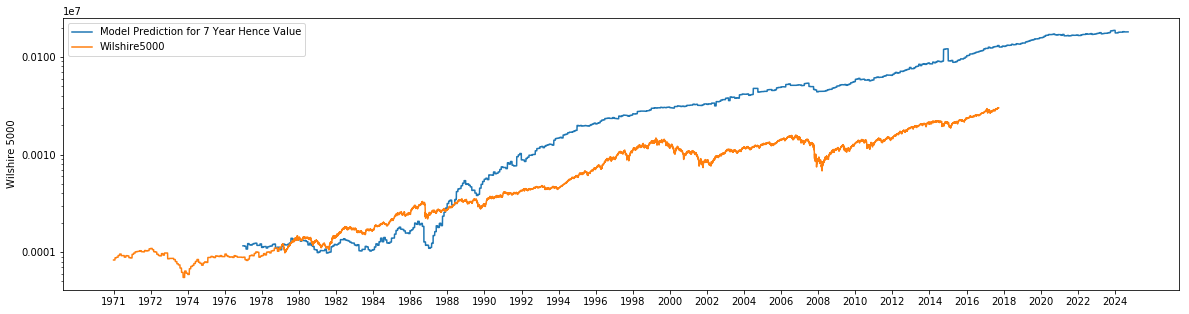

In [110]:
# Find the Train Target

indicesOfTrain=train.index
indicesOfTrainTarget=indicesOfTrain + pd.Timedelta(weeks=7*52)

trainTargetRows=[]
for i in indicesOfTrainTarget:
     trainTargetRows.append(wilshire.loc[i])               

trainTargetRows=pd.DataFrame(trainTargetRows,index=indicesOfTrainTarget)
trainTarget=trainTargetRows['Wilshire5000']   ## Select Target from Rows of Target Dates
trainTarget=pd.DataFrame(trainTarget,index=trainTargetRows.index)

trainTarget=np.ravel(trainTarget,order='c')


# Bagging the Network
bilbo=BaggingRegressor(base_estimator=clf, 
                     n_estimators=20,
                     max_samples=.1,        
                     max_features=.1,      
                     bootstrap=True, 
                     bootstrap_features=False,
                     oob_score=False, 
                     warm_start=True,
                     n_jobs=1, 
                     random_state=None, 
                     verbose=1)


bilbo.fit(train,trainTarget)


## Make Bagged Predictions for both train and test for visualization

graph(clf)

In [ ]:
# Optimize: loss 34,000 validation .9939

In [ ]:
# Notes

In [111]:
## Train the Network on Random Patches to 2007-10-9 Peak

train=wilshire['1971-1-1':'2000-10-9']  
test=wilshire['2000-10-9':date.today()] 

# Normalize Train and Test Sets using only train means and standard deviations

mean=train.mean(axis=0)
std=train.std(axis=0)

train=(train-mean)/std
test=(test-mean)/std

What is the shape of the train set: (10875, 5664)
What is the shape of the test set: (6549, 5664)
How many NaNs in Train Set? 10875
How many NaNs in Test Set? 10875
What is the shape of the train set: (10875, 5663)
What is the shape of the test set: (6549, 5663)
How many NaNs in Train Set? 0
How many NaNs in Test Set? 0
(10875,)
Iteration 1, loss = 27283018.11355504
Validation score: -1.702300
Iteration 2, loss = 27031055.49469210
Validation score: -1.555520
Iteration 3, loss = 23252112.20739903
Validation score: -0.089098
Iteration 4, loss = 8787552.99554639
Validation score: 0.718272
Iteration 5, loss = 2477779.50918365
Validation score: 0.661804
Iteration 6, loss = 2098317.02182752
Validation score: 0.773121
Iteration 7, loss = 1721664.14243930
Validation score: 0.867830
Iteration 8, loss = 1291609.96101323
Validation score: 0.954108
Iteration 9, loss = 742572.34450226
Validation score: 0.965329
Iteration 10, loss = 558215.55394432
Validation score: 0.965046
Iteration 11, loss = 352

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 26753684.97782739
Validation score: -1.690332
Iteration 2, loss = 26558008.80049108
Validation score: -1.566364
Iteration 3, loss = 23458143.23932029
Validation score: -0.258933
Iteration 4, loss = 9362684.48170874
Validation score: 0.703422
Iteration 5, loss = 3697833.19388001
Validation score: 0.652820
Iteration 6, loss = 2141103.67893030
Validation score: 0.442895
Iteration 7, loss = 2791815.73733370
Validation score: 0.759462
Iteration 8, loss = 2371353.07539289
Validation score: 0.946504
Iteration 9, loss = 1235273.54988460
Validation score: 0.954683
Iteration 10, loss = 666696.66448635
Validation score: 0.909657
Iteration 11, loss = 528035.60172614
Validation score: 0.936865
Iteration 12, loss = 473840.78285539
Validation score: 0.946126
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 27042174.68175175
Validation score: -1.873931
Iteration 2, loss = 26811919.74046433
Validation score: -1.721956


/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 25310391.04086091
Validation score: -1.865814
Iteration 2, loss = 25123444.06243041
Validation score: -1.749778
Iteration 3, loss = 22080957.64765202
Validation score: -0.455103
Iteration 4, loss = 8645878.16630815
Validation score: 0.679314
Iteration 5, loss = 3989984.50772319
Validation score: 0.352249
Iteration 6, loss = 3012198.05274351
Validation score: 0.770909
Iteration 7, loss = 2437802.26608825
Validation score: 0.810482
Iteration 8, loss = 1753724.65513002
Validation score: 0.916134
Iteration 9, loss = 904639.79903226
Validation score: 0.940540
Iteration 10, loss = 572906.30436129
Validation score: 0.876678
Iteration 11, loss = 657306.59264357
Validation score: 0.953823
Iteration 12, loss = 412478.06499567
Validation score: 0.964600
Iteration 13, loss = 277529.06766881
Validation score: 0.976313
Iteration 14, loss = 229198.87191557
Validation score: 0.978437
Iteration 15, loss = 189056.81638697
Validation score: 0.975722
Iteration 16, loss = 186689.5758323

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 27051920.61644051
Validation score: -1.722955
Iteration 2, loss = 26852686.33468487
Validation score: -1.598575
Iteration 3, loss = 23630091.23525006
Validation score: -0.268563
Iteration 4, loss = 8400410.99233518
Validation score: 0.660827
Iteration 5, loss = 2908170.91374200
Validation score: 0.720750
Iteration 6, loss = 1870288.13765755
Validation score: 0.784187
Iteration 7, loss = 1265436.56002894
Validation score: 0.860302
Iteration 8, loss = 880383.66444463
Validation score: 0.898183
Iteration 9, loss = 785980.09027818
Validation score: 0.902424
Iteration 10, loss = 708095.24960023
Validation score: 0.959407
Iteration 11, loss = 366584.58687223
Validation score: 0.968717
Iteration 12, loss = 257156.72754390
Validation score: 0.979612
Iteration 13, loss = 202104.68725855
Validation score: 0.981683
Iteration 14, loss = 170236.76387133
Validation score: 0.985316
Iteration 15, loss = 151564.64764236
Validation score: 0.987582
Iteration 16, loss = 148114.42485341

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 26380899.45170692
Validation score: -1.855650
Iteration 2, loss = 26144804.21333331
Validation score: -1.707510
Iteration 3, loss = 22666619.29567689
Validation score: -0.157970
Iteration 4, loss = 8477145.86568274
Validation score: 0.738626
Iteration 5, loss = 4056542.98137733
Validation score: 0.655505
Iteration 6, loss = 1876189.54323616
Validation score: 0.592222
Iteration 7, loss = 2004521.22750032
Validation score: 0.783302
Iteration 8, loss = 1607300.52978576
Validation score: 0.935537
Iteration 9, loss = 876695.97846810
Validation score: 0.951330
Iteration 10, loss = 608435.71416498
Validation score: 0.966843
Iteration 11, loss = 414637.89626041
Validation score: 0.972808
Iteration 12, loss = 332997.83644274
Validation score: 0.975783
Iteration 13, loss = 259528.12024485
Validation score: 0.980145
Iteration 14, loss = 218401.61604111
Validation score: 0.981791
Iteration 15, loss = 206233.62634053
Validation score: 0.982640
Iteration 16, loss = 189809.3589709

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 27238557.68687437
Validation score: -1.611393
Iteration 2, loss = 27045422.90121701
Validation score: -1.505493
Iteration 3, loss = 24282216.15346642
Validation score: -0.332874
Iteration 4, loss = 9959126.34710595
Validation score: 0.599694
Iteration 5, loss = 3953641.74468511
Validation score: 0.584149
Iteration 6, loss = 2673095.11975304
Validation score: 0.670153
Iteration 7, loss = 1925758.05944444
Validation score: 0.862819
Iteration 8, loss = 944443.57111071
Validation score: 0.919468
Iteration 9, loss = 626808.01278682
Validation score: 0.950648
Iteration 10, loss = 427587.03367767
Validation score: 0.948581
Iteration 11, loss = 445411.48901749
Validation score: 0.959140
Iteration 12, loss = 396163.85866567
Validation score: 0.968815
Iteration 13, loss = 256307.23607078
Validation score: 0.973871
Iteration 14, loss = 212456.70859690
Validation score: 0.977026
Iteration 15, loss = 191190.74617446
Validation score: 0.977514
Iteration 16, loss = 206486.21451067

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 28105662.07897968
Validation score: -1.867534
Iteration 2, loss = 27892138.92647083
Validation score: -1.733622
Iteration 3, loss = 24431739.65059761
Validation score: -0.254576
Iteration 4, loss = 8947839.59528370
Validation score: 0.618475
Iteration 5, loss = 3365313.52246280
Validation score: 0.747810
Iteration 6, loss = 1767197.49477605
Validation score: 0.807594
Iteration 7, loss = 1102296.74133712
Validation score: 0.854108
Iteration 8, loss = 817674.59225717
Validation score: 0.850606
Iteration 9, loss = 763441.50879747
Validation score: 0.923529
Iteration 10, loss = 565098.35462166
Validation score: 0.936549
Iteration 11, loss = 380616.79442801
Validation score: 0.957433
Iteration 12, loss = 324966.09921939
Validation score: 0.965229
Iteration 13, loss = 211346.16748897
Validation score: 0.976244
Iteration 14, loss = 177985.65585289
Validation score: 0.979006
Iteration 15, loss = 147329.16563091
Validation score: 0.982204
Iteration 16, loss = 140430.99319123

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 27442403.47951798
Validation score: -1.900784
Iteration 2, loss = 27197566.90984276
Validation score: -1.730718
Iteration 3, loss = 23272415.62828149
Validation score: 0.035502
Iteration 4, loss = 7530760.64514569
Validation score: 0.800081
Iteration 5, loss = 4204024.69356747
Validation score: 0.644259
Iteration 6, loss = 2249887.44903621
Validation score: 0.829288
Iteration 7, loss = 1092035.74590915
Validation score: 0.834776
Iteration 8, loss = 1171057.14737309
Validation score: 0.946815
Iteration 9, loss = 715089.30201921
Validation score: 0.952485
Iteration 10, loss = 507586.15199061
Validation score: 0.967607
Iteration 11, loss = 352891.30774259
Validation score: 0.975008
Iteration 12, loss = 287184.72673893
Validation score: 0.980758
Iteration 13, loss = 252991.17213910
Validation score: 0.984567
Iteration 14, loss = 199732.28916000
Validation score: 0.985408
Iteration 15, loss = 181834.13231694
Validation score: 0.988583
Iteration 16, loss = 155788.29059214

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 27338491.37031592
Validation score: -1.802169
Iteration 2, loss = 27142610.36331540
Validation score: -1.692081
Iteration 3, loss = 24321490.81062629
Validation score: -0.391277
Iteration 4, loss = 9200374.71113685
Validation score: 0.607688
Iteration 5, loss = 3086232.71930298
Validation score: 0.684377
Iteration 6, loss = 2218690.90344579
Validation score: 0.821551
Iteration 7, loss = 1433936.12816659
Validation score: 0.887089
Iteration 8, loss = 798573.25046769
Validation score: 0.933148
Iteration 9, loss = 492943.47952508
Validation score: 0.953297
Iteration 10, loss = 446793.25945667
Validation score: 0.966719
Iteration 11, loss = 346878.88507750
Validation score: 0.973056
Iteration 12, loss = 276844.81825476
Validation score: 0.976931
Iteration 13, loss = 214573.78497744
Validation score: 0.978743
Iteration 14, loss = 197043.36682734
Validation score: 0.978552
Iteration 15, loss = 188443.11501946
Validation score: 0.983054
Iteration 16, loss = 163710.14058888

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 26015116.98414892
Validation score: -1.757653
Iteration 2, loss = 25790994.36639572
Validation score: -1.612969
Iteration 3, loss = 22359356.05322411
Validation score: -0.108387
Iteration 4, loss = 8227664.05767815
Validation score: 0.724443
Iteration 5, loss = 4337333.43440712
Validation score: 0.554898
Iteration 6, loss = 2712090.48919955
Validation score: 0.635795
Iteration 7, loss = 1897519.41082380
Validation score: 0.842942
Iteration 8, loss = 1528639.81850987
Validation score: 0.956038
Iteration 9, loss = 866232.22769267
Validation score: 0.968786
Iteration 10, loss = 591393.64091964
Validation score: 0.955671
Iteration 11, loss = 410224.38540110
Validation score: 0.974806
Iteration 12, loss = 304961.81446293
Validation score: 0.976070
Iteration 13, loss = 234462.40165416
Validation score: 0.983114
Iteration 14, loss = 190984.70469934
Validation score: 0.981518
Iteration 15, loss = 172187.37216173
Validation score: 0.985322
Iteration 16, loss = 148239.1034329

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 25632370.91102564
Validation score: -1.797974
Iteration 2, loss = 25392249.68400973
Validation score: -1.654980
Iteration 3, loss = 21821133.86491949
Validation score: -0.186586
Iteration 4, loss = 7796432.51259410
Validation score: 0.689047
Iteration 5, loss = 3236039.76944713
Validation score: 0.664451
Iteration 6, loss = 1643390.34060449
Validation score: 0.794301
Iteration 7, loss = 1190433.17438500
Validation score: 0.821507
Iteration 8, loss = 934571.85143216
Validation score: 0.904140
Iteration 9, loss = 617456.16797635
Validation score: 0.926584
Iteration 10, loss = 475728.31844631
Validation score: 0.937212
Iteration 11, loss = 443006.22440291
Validation score: 0.946510
Iteration 12, loss = 345198.33031887
Validation score: 0.966476
Iteration 13, loss = 221788.13875690
Validation score: 0.967156
Iteration 14, loss = 196953.10747180
Validation score: 0.971488
Iteration 15, loss = 192972.04013211
Validation score: 0.973904
Iteration 16, loss = 217981.14005625

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 25765280.58776635
Validation score: -1.869088
Iteration 2, loss = 25599627.77810291
Validation score: -1.759061
Iteration 3, loss = 22956137.19879043
Validation score: -0.499103
Iteration 4, loss = 8433480.60852450
Validation score: 0.717020
Iteration 5, loss = 3568179.68212556
Validation score: 0.520236
Iteration 6, loss = 2393746.73061107
Validation score: 0.678798
Iteration 7, loss = 1914578.28305641
Validation score: 0.829669
Iteration 8, loss = 1525224.59655445
Validation score: 0.954116
Iteration 9, loss = 802267.07502501
Validation score: 0.960510
Iteration 10, loss = 545567.96451069
Validation score: 0.953253
Iteration 11, loss = 467863.59299401
Validation score: 0.965246
Iteration 12, loss = 416620.42502249
Validation score: 0.954024
Iteration 13, loss = 299011.72793690
Validation score: 0.965034
Iteration 14, loss = 269322.83481281
Validation score: 0.968769
Iteration 15, loss = 215687.27775387
Validation score: 0.976133
Iteration 16, loss = 190469.2726524

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 27597596.41153402
Validation score: -1.776138
Iteration 2, loss = 27382540.89491498
Validation score: -1.646472
Iteration 3, loss = 23882492.50454023
Validation score: -0.338729
Iteration 4, loss = 9205551.89904680
Validation score: 0.657626
Iteration 5, loss = 3528092.24610697
Validation score: 0.468641
Iteration 6, loss = 3132857.70104024
Validation score: 0.809733
Iteration 7, loss = 1600895.91177737
Validation score: 0.892777
Iteration 8, loss = 867173.84415120
Validation score: 0.941562
Iteration 9, loss = 623457.08451125
Validation score: 0.950255
Iteration 10, loss = 490834.57210764
Validation score: 0.944024
Iteration 11, loss = 367673.24949424
Validation score: 0.952591
Iteration 12, loss = 280616.90067069
Validation score: 0.960937
Iteration 13, loss = 236098.43060090
Validation score: 0.969444
Iteration 14, loss = 174981.00200414
Validation score: 0.973616
Iteration 15, loss = 144775.97942441
Validation score: 0.976593
Iteration 16, loss = 130077.18588685

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 28169878.97655569
Validation score: -1.827613
Iteration 2, loss = 27964887.58948655
Validation score: -1.706477
Iteration 3, loss = 24816078.08947711
Validation score: -0.425382
Iteration 4, loss = 10155615.95098360
Validation score: 0.646095
Iteration 5, loss = 4138671.66686793
Validation score: 0.393626
Iteration 6, loss = 4030002.86114500
Validation score: 0.828508
Iteration 7, loss = 1883229.43347644
Validation score: 0.901161
Iteration 8, loss = 1134873.43023396
Validation score: 0.935308
Iteration 9, loss = 602748.30914321
Validation score: 0.949381
Iteration 10, loss = 538086.99399752
Validation score: 0.947210
Iteration 11, loss = 443647.04840886
Validation score: 0.952761
Iteration 12, loss = 407939.55099681
Validation score: 0.962189
Iteration 13, loss = 315635.00585079
Validation score: 0.968634
Iteration 14, loss = 316391.66496202
Validation score: 0.965361
Iteration 15, loss = 306933.30388737
Validation score: 0.977768
Iteration 16, loss = 212548.100259

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 25056529.01746803
Validation score: -1.759534
Iteration 2, loss = 24856098.91024569
Validation score: -1.631488
Iteration 3, loss = 21670000.53457019
Validation score: -0.294031
Iteration 4, loss = 8731836.94187052
Validation score: 0.610179
Iteration 5, loss = 2975810.25645548
Validation score: 0.659217
Iteration 6, loss = 1940065.34407417
Validation score: 0.801499
Iteration 7, loss = 1163903.71943482
Validation score: 0.855374
Iteration 8, loss = 919831.26245606
Validation score: 0.910047
Iteration 9, loss = 685810.90279233
Validation score: 0.932315
Iteration 10, loss = 492917.52758511
Validation score: 0.951124
Iteration 11, loss = 393065.82836414
Validation score: 0.959668
Iteration 12, loss = 282630.72760844
Validation score: 0.970024
Iteration 13, loss = 237907.47591278
Validation score: 0.973521
Iteration 14, loss = 206703.36226847
Validation score: 0.973576
Iteration 15, loss = 202521.19655549
Validation score: 0.979265
Iteration 16, loss = 174677.02867670

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 27470979.17938710
Validation score: -1.509925
Iteration 2, loss = 27230225.01440344
Validation score: -1.376026
Iteration 3, loss = 23557214.42767676
Validation score: -0.109472
Iteration 4, loss = 8625557.48435215
Validation score: 0.691279
Iteration 5, loss = 2758247.98685966
Validation score: 0.741067
Iteration 6, loss = 1527162.19771352
Validation score: 0.775429
Iteration 7, loss = 1549945.26169567
Validation score: 0.861630
Iteration 8, loss = 932584.11408370
Validation score: 0.950380
Iteration 9, loss = 532489.84666182
Validation score: 0.955695
Iteration 10, loss = 463597.62103861
Validation score: 0.973303
Iteration 11, loss = 323848.91026193
Validation score: 0.977226
Iteration 12, loss = 248390.28400076
Validation score: 0.982620
Iteration 13, loss = 216018.47473038
Validation score: 0.983985
Iteration 14, loss = 180919.37373692
Validation score: 0.986803
Iteration 15, loss = 151688.34995341
Validation score: 0.988238
Iteration 16, loss = 135928.04453373

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 27075728.20648706
Validation score: -1.745813
Iteration 2, loss = 26885306.22449506
Validation score: -1.626834
Iteration 3, loss = 23817800.27807458
Validation score: -0.357338
Iteration 4, loss = 8882344.67765936
Validation score: 0.510443
Iteration 5, loss = 3374789.21472536
Validation score: 0.623249
Iteration 6, loss = 2520224.36498057
Validation score: 0.795201
Iteration 7, loss = 1324958.96788556
Validation score: 0.885438
Iteration 8, loss = 1097081.83252985
Validation score: 0.932700
Iteration 9, loss = 754163.16000608
Validation score: 0.941094
Iteration 10, loss = 793873.72327197
Validation score: 0.963071
Iteration 11, loss = 505476.45197253
Validation score: 0.972330
Iteration 12, loss = 341749.48657437
Validation score: 0.978294
Iteration 13, loss = 226119.88791366
Validation score: 0.977995
Iteration 14, loss = 202919.62651255
Validation score: 0.982929
Iteration 15, loss = 178470.85084119
Validation score: 0.984963
Iteration 16, loss = 145075.3383896

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 58.2min finished


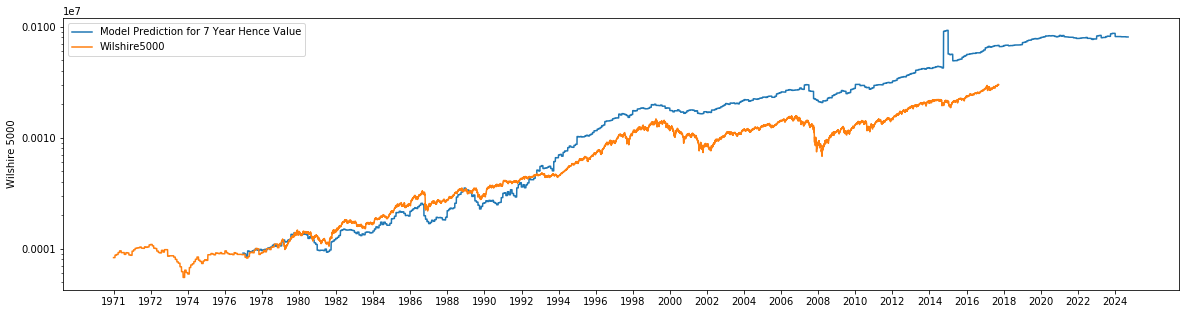

In [112]:
# Find the Train Target

indicesOfTrain=train.index
indicesOfTrainTarget=indicesOfTrain + pd.Timedelta(weeks=7*52)

trainTargetRows=[]
for i in indicesOfTrainTarget:
     trainTargetRows.append(wilshire.loc[i])               

trainTargetRows=pd.DataFrame(trainTargetRows,index=indicesOfTrainTarget)
trainTarget=trainTargetRows['Wilshire5000']   ## Select Target from Rows of Target Dates
trainTarget=pd.DataFrame(trainTarget,index=trainTargetRows.index)

trainTarget=np.ravel(trainTarget,order='c')


# Bagging the Network
bilbo=BaggingRegressor(base_estimator=clf, 
                     n_estimators=20,
                     max_samples=.1,        
                     max_features=.1,      
                     bootstrap=True, 
                     bootstrap_features=False,
                     oob_score=False, 
                     warm_start=False,
                     n_jobs=1, 
                     random_state=None, 
                     verbose=1)


bilbo.fit(train,trainTarget)


## Make Bagged Predictions for both train and test for visualization

graph(clf)

In [143]:
#Optimize validation 99.39

In [144]:
# Notes

In [113]:
## Train the Network on Random Patches up to the Present 

train=wilshire['1971-1-1':'2011-9-16']  
test=wilshire['2011-9-16':date.today()] 

# Normalize Train and Test Sets using only train means and standard deviations

mean=train.mean(axis=0)
std=train.std(axis=0)

train=(train-mean)/std
test=(test-mean)/std


What is the shape of the train set: (14869, 5664)
What is the shape of the test set: (2555, 5664)
How many NaNs in Train Set? 14869
How many NaNs in Test Set? 14869
What is the shape of the train set: (14869, 5663)
What is the shape of the test set: (2555, 5663)
How many NaNs in Train Set? 0
How many NaNs in Test Set? 0
(14869,)
Iteration 1, loss = 60749419.39204931
Validation score: -1.695564
Iteration 2, loss = 59512129.81505562
Validation score: -1.408287
Iteration 3, loss = 37752734.34759308
Validation score: -0.013749
Iteration 4, loss = 13854918.99928289
Validation score: 0.494570
Iteration 5, loss = 8486713.20536409
Validation score: 0.684728
Iteration 6, loss = 4787479.77072570
Validation score: 0.836175
Iteration 7, loss = 2258298.12766739
Validation score: 0.898616
Iteration 8, loss = 1344128.63974082
Validation score: 0.931067
Iteration 9, loss = 1139653.69020785
Validation score: 0.962633
Iteration 10, loss = 711507.33011479
Validation score: 0.979896
Iteration 11, loss = 5

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 62649988.85173471
Validation score: -1.582626
Iteration 2, loss = 61120334.14508797
Validation score: -1.288717
Iteration 3, loss = 37488095.62863272
Validation score: -0.021813
Iteration 4, loss = 13981345.34344781
Validation score: 0.522479
Iteration 5, loss = 7701525.67313056
Validation score: 0.695953
Iteration 6, loss = 5067402.62830711
Validation score: 0.846943
Iteration 7, loss = 2451067.87323830
Validation score: 0.923382
Iteration 8, loss = 1497693.74985267
Validation score: 0.951559
Iteration 9, loss = 1156680.62303804
Validation score: 0.969850
Iteration 10, loss = 889736.18642533
Validation score: 0.977204
Iteration 11, loss = 763169.88658216
Validation score: 0.976434
Iteration 12, loss = 611700.34188427
Validation score: 0.979783
Iteration 13, loss = 455079.15659549
Validation score: 0.985749
Iteration 14, loss = 406652.54097278
Validation score: 0.988736
Iteration 15, loss = 348627.61098578
Validation score: 0.990131
Iteration 16, loss = 297480.54089

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 70771035.13324955
Validation score: -1.913856
Iteration 2, loss = 69431353.20193905
Validation score: -1.621834
Iteration 3, loss = 45198493.03278938
Validation score: 0.146306
Iteration 4, loss = 13580097.73607807
Validation score: 0.513816
Iteration 5, loss = 8182513.22526944
Validation score: 0.694995
Iteration 6, loss = 4090690.64815417
Validation score: 0.868332
Iteration 7, loss = 2173678.19627142
Validation score: 0.935491
Iteration 8, loss = 1238324.11051397
Validation score: 0.959670
Iteration 9, loss = 867566.90090811
Validation score: 0.979511
Iteration 10, loss = 588643.28425013
Validation score: 0.982233
Iteration 11, loss = 477183.04384312
Validation score: 0.984744
Iteration 12, loss = 367088.42619148
Validation score: 0.987901
Iteration 13, loss = 328044.21517318
Validation score: 0.989134
Iteration 14, loss = 282414.55550418
Validation score: 0.990081
Iteration 15, loss = 233960.30644566
Validation score: 0.991709
Iteration 16, loss = 211256.7369434

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 67352712.73358889
Validation score: -1.748365
Iteration 2, loss = 65997670.56061234
Validation score: -1.472193
Iteration 3, loss = 40542046.37560628
Validation score: 0.115315
Iteration 4, loss = 13462970.97023925
Validation score: 0.524613
Iteration 5, loss = 8105639.48341165
Validation score: 0.698278
Iteration 6, loss = 4341305.15325507
Validation score: 0.861970
Iteration 7, loss = 2009728.07845527
Validation score: 0.937037
Iteration 8, loss = 1023533.21955749
Validation score: 0.954899
Iteration 9, loss = 868992.75484340
Validation score: 0.974846
Iteration 10, loss = 590563.47793421
Validation score: 0.980291
Iteration 11, loss = 474728.13938266
Validation score: 0.982200
Iteration 12, loss = 393203.27431907
Validation score: 0.985126
Iteration 13, loss = 333500.72503241
Validation score: 0.986604
Iteration 14, loss = 294910.20980205
Validation score: 0.989102
Iteration 15, loss = 251268.24447158
Validation score: 0.990304
Iteration 16, loss = 224762.8135726

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 64169057.12257459
Validation score: -1.856970
Iteration 2, loss = 62920223.17603179
Validation score: -1.582047
Iteration 3, loss = 39723983.08634684
Validation score: 0.231494
Iteration 4, loss = 12349205.43862502
Validation score: 0.599228
Iteration 5, loss = 6091841.16886427
Validation score: 0.674053
Iteration 6, loss = 3657796.60666358
Validation score: 0.855788
Iteration 7, loss = 1828820.68411475
Validation score: 0.909014
Iteration 8, loss = 1223093.25340535
Validation score: 0.934965
Iteration 9, loss = 996013.85033833
Validation score: 0.962255
Iteration 10, loss = 656228.65055554
Validation score: 0.977979
Iteration 11, loss = 538969.07881683
Validation score: 0.981423
Iteration 12, loss = 435307.90710528
Validation score: 0.981774
Iteration 13, loss = 390755.69323588
Validation score: 0.982500
Iteration 14, loss = 341693.42669870
Validation score: 0.986829
Iteration 15, loss = 282969.71952151
Validation score: 0.987612
Iteration 16, loss = 246030.5124746

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 66089047.61145469
Validation score: -1.670915
Iteration 2, loss = 64531772.41146880
Validation score: -1.384510
Iteration 3, loss = 38591088.01570527
Validation score: -0.128860
Iteration 4, loss = 13794329.44552100
Validation score: 0.407134
Iteration 5, loss = 7805162.09855157
Validation score: 0.723056
Iteration 6, loss = 4239709.60373623
Validation score: 0.814329
Iteration 7, loss = 2141355.47275690
Validation score: 0.919044
Iteration 8, loss = 1087128.42731913
Validation score: 0.944326
Iteration 9, loss = 864338.07311820
Validation score: 0.959852
Iteration 10, loss = 653526.86617473
Validation score: 0.967896
Iteration 11, loss = 581794.90046259
Validation score: 0.976685
Iteration 12, loss = 409275.23335411
Validation score: 0.979328
Iteration 13, loss = 340673.98089751
Validation score: 0.981144
Iteration 14, loss = 306286.01475572
Validation score: 0.982824
Iteration 15, loss = 278684.16697880
Validation score: 0.984314
Iteration 16, loss = 248893.756931

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 64524026.53873538
Validation score: -1.694546
Iteration 2, loss = 63681545.72901152
Validation score: -1.497572
Iteration 3, loss = 45959463.56262840
Validation score: 0.565888
Iteration 4, loss = 13635733.27686739
Validation score: 0.471416
Iteration 5, loss = 10533470.26727582
Validation score: 0.843917
Iteration 6, loss = 5324866.20856446
Validation score: 0.864071
Iteration 7, loss = 3502494.40980216
Validation score: 0.956847
Iteration 8, loss = 1397757.13734947
Validation score: 0.962512
Iteration 9, loss = 1059504.48345230
Validation score: 0.967608
Iteration 10, loss = 759755.74646758
Validation score: 0.972252
Iteration 11, loss = 579036.81927681
Validation score: 0.974727
Iteration 12, loss = 455425.05499363
Validation score: 0.978619
Iteration 13, loss = 391644.21614707
Validation score: 0.980962
Iteration 14, loss = 330287.20465916
Validation score: 0.982972
Iteration 15, loss = 297297.84581248
Validation score: 0.985125
Iteration 16, loss = 262864.23849

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 67309008.88691203
Validation score: -1.612105
Iteration 2, loss = 65937457.05015633
Validation score: -1.319337
Iteration 3, loss = 38962626.00510030
Validation score: -0.177152
Iteration 4, loss = 13417195.29797289
Validation score: 0.434493
Iteration 5, loss = 8595605.47096218
Validation score: 0.767133
Iteration 6, loss = 4686018.18091324
Validation score: 0.802557
Iteration 7, loss = 3200125.73324027
Validation score: 0.914910
Iteration 8, loss = 1721854.68981269
Validation score: 0.927078
Iteration 9, loss = 1378361.95664423
Validation score: 0.947265
Iteration 10, loss = 950750.05833154
Validation score: 0.959776
Iteration 11, loss = 656020.43967137
Validation score: 0.973586
Iteration 12, loss = 531433.90680473
Validation score: 0.974684
Iteration 13, loss = 417380.83609560
Validation score: 0.983680
Iteration 14, loss = 341730.71123093
Validation score: 0.986531
Iteration 15, loss = 292577.48815137
Validation score: 0.988844
Iteration 16, loss = 247493.69532

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 63960644.67872165
Validation score: -1.629837
Iteration 2, loss = 62940291.69886936
Validation score: -1.425157
Iteration 3, loss = 43477108.30264257
Validation score: 0.508729
Iteration 4, loss = 13797862.10303850
Validation score: 0.458128
Iteration 5, loss = 10679014.53217607
Validation score: 0.816616
Iteration 6, loss = 5849177.64374504
Validation score: 0.806667
Iteration 7, loss = 3949747.43080172
Validation score: 0.943264
Iteration 8, loss = 1977856.15221659
Validation score: 0.933485
Iteration 9, loss = 1476427.93436206
Validation score: 0.955305
Iteration 10, loss = 944339.32557245
Validation score: 0.960788
Iteration 11, loss = 735929.53902336
Validation score: 0.966476
Iteration 12, loss = 652306.99628431
Validation score: 0.971475
Iteration 13, loss = 498358.01305686
Validation score: 0.979935
Iteration 14, loss = 373367.11933890
Validation score: 0.982972
Iteration 15, loss = 322668.31235420
Validation score: 0.985671
Iteration 16, loss = 286601.72098

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 67686495.17316127
Validation score: -1.545945
Iteration 2, loss = 66617680.03085500
Validation score: -1.329240
Iteration 3, loss = 44464181.03092985
Validation score: 0.542421
Iteration 4, loss = 12193380.10384888
Validation score: 0.601748
Iteration 5, loss = 7928500.64769955
Validation score: 0.811900
Iteration 6, loss = 4584920.12491909
Validation score: 0.857112
Iteration 7, loss = 2407505.71971599
Validation score: 0.899866
Iteration 8, loss = 1634610.20510234
Validation score: 0.924422
Iteration 9, loss = 1227892.36105863
Validation score: 0.955462
Iteration 10, loss = 771831.97760628
Validation score: 0.974091
Iteration 11, loss = 571887.42221050
Validation score: 0.986772
Iteration 12, loss = 421989.63801884
Validation score: 0.987396
Iteration 13, loss = 356815.77977418
Validation score: 0.985974
Iteration 14, loss = 304913.70976804
Validation score: 0.988758
Iteration 15, loss = 276820.88881822
Validation score: 0.990671
Iteration 16, loss = 238427.000387

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 64880531.58431984
Validation score: -1.973508
Iteration 2, loss = 63600465.19639190
Validation score: -1.683948
Iteration 3, loss = 38005577.95916889
Validation score: -0.019142
Iteration 4, loss = 14788178.53072378
Validation score: 0.338930
Iteration 5, loss = 9244389.04931114
Validation score: 0.636805
Iteration 6, loss = 5331007.29082424
Validation score: 0.756405
Iteration 7, loss = 3050290.72707328
Validation score: 0.898557
Iteration 8, loss = 1353476.52960252
Validation score: 0.939483
Iteration 9, loss = 1041025.88094683
Validation score: 0.961849
Iteration 10, loss = 717249.92568111
Validation score: 0.973432
Iteration 11, loss = 561804.10372412
Validation score: 0.977099
Iteration 12, loss = 470923.93540608
Validation score: 0.980891
Iteration 13, loss = 351113.48853444
Validation score: 0.982785
Iteration 14, loss = 325597.64807185
Validation score: 0.984613
Iteration 15, loss = 281955.91621465
Validation score: 0.986176
Iteration 16, loss = 253178.38138

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 62554379.74989370
Validation score: -1.561069
Iteration 2, loss = 61352999.85892466
Validation score: -1.310796
Iteration 3, loss = 38636253.39624295
Validation score: 0.170816
Iteration 4, loss = 13550399.41075687
Validation score: 0.475913
Iteration 5, loss = 9175956.76862493
Validation score: 0.749269
Iteration 6, loss = 5353346.47866486
Validation score: 0.796631
Iteration 7, loss = 3049502.62524464
Validation score: 0.915623
Iteration 8, loss = 1661587.57125976
Validation score: 0.935138
Iteration 9, loss = 1127488.57711920
Validation score: 0.950434
Iteration 10, loss = 887253.18851728
Validation score: 0.967967
Iteration 11, loss = 612691.45969879
Validation score: 0.976944
Iteration 12, loss = 458319.39857189
Validation score: 0.983086
Iteration 13, loss = 370510.49903561
Validation score: 0.984780
Iteration 14, loss = 332664.29957847
Validation score: 0.986784
Iteration 15, loss = 272358.69146766
Validation score: 0.988636
Iteration 16, loss = 232844.157985

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 62396686.13163050
Validation score: -1.765093
Iteration 2, loss = 61264269.58955128
Validation score: -1.499177
Iteration 3, loss = 39825278.11598663
Validation score: 0.160474
Iteration 4, loss = 13547349.36831737
Validation score: 0.439478
Iteration 5, loss = 9312442.55080266
Validation score: 0.731670
Iteration 6, loss = 5140316.71469390
Validation score: 0.837311
Iteration 7, loss = 2323101.58725586
Validation score: 0.896733
Iteration 8, loss = 1579218.76559666
Validation score: 0.926850
Iteration 9, loss = 1172127.63428037
Validation score: 0.949927
Iteration 10, loss = 814518.78794940
Validation score: 0.970660
Iteration 11, loss = 625926.78378985
Validation score: 0.980006
Iteration 12, loss = 480485.14857987
Validation score: 0.986575
Iteration 13, loss = 369073.83387999
Validation score: 0.987673
Iteration 14, loss = 318756.45606990
Validation score: 0.988023
Iteration 15, loss = 281617.07911095
Validation score: 0.989805
Iteration 16, loss = 252321.561391

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 65941631.82744586
Validation score: -1.603956
Iteration 2, loss = 64809989.76816092
Validation score: -1.390713
Iteration 3, loss = 43916946.85098884
Validation score: 0.307268
Iteration 4, loss = 12894066.56432499
Validation score: 0.518268
Iteration 5, loss = 7233723.50426957
Validation score: 0.711326
Iteration 6, loss = 4227078.34655420
Validation score: 0.829691
Iteration 7, loss = 2108647.41306017
Validation score: 0.918174
Iteration 8, loss = 1188647.56262352
Validation score: 0.947969
Iteration 9, loss = 920006.82191045
Validation score: 0.968203
Iteration 10, loss = 633683.78859853
Validation score: 0.975977
Iteration 11, loss = 490001.68800213
Validation score: 0.978542
Iteration 12, loss = 405893.66818419
Validation score: 0.981930
Iteration 13, loss = 338575.84460963
Validation score: 0.983693
Iteration 14, loss = 299330.41742516
Validation score: 0.985952
Iteration 15, loss = 260681.73607786
Validation score: 0.988122
Iteration 16, loss = 230885.2334746

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 63467602.57123360
Validation score: -1.727193
Iteration 2, loss = 62325754.69769976
Validation score: -1.461114
Iteration 3, loss = 40462919.09619967
Validation score: 0.035595
Iteration 4, loss = 13526008.26751889
Validation score: 0.537370
Iteration 5, loss = 6792716.52972795
Validation score: 0.749172
Iteration 6, loss = 3093304.16810225
Validation score: 0.896482
Iteration 7, loss = 1423206.15274969
Validation score: 0.942661
Iteration 8, loss = 1075910.18806333
Validation score: 0.960240
Iteration 9, loss = 875535.40385960
Validation score: 0.972694
Iteration 10, loss = 597354.47514039
Validation score: 0.975131
Iteration 11, loss = 444801.98784361
Validation score: 0.979348
Iteration 12, loss = 375440.74171939
Validation score: 0.981571
Iteration 13, loss = 318368.58214759
Validation score: 0.985235
Iteration 14, loss = 281320.02350816
Validation score: 0.987060
Iteration 15, loss = 247301.83567972
Validation score: 0.986521
Iteration 16, loss = 231936.0662680

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 61259275.04771140
Validation score: -1.593065
Iteration 2, loss = 59995625.84650637
Validation score: -1.318308
Iteration 3, loss = 37589330.31438145
Validation score: 0.132255
Iteration 4, loss = 12638502.46833104
Validation score: 0.551367
Iteration 5, loss = 7291222.13215722
Validation score: 0.704428
Iteration 6, loss = 3999413.49704328
Validation score: 0.861369
Iteration 7, loss = 1910268.88362086
Validation score: 0.929400
Iteration 8, loss = 1176154.28566656
Validation score: 0.950563
Iteration 9, loss = 952391.09226209
Validation score: 0.975610
Iteration 10, loss = 706976.31648403
Validation score: 0.979537
Iteration 11, loss = 566776.09981148
Validation score: 0.978397
Iteration 12, loss = 484751.21503570
Validation score: 0.981365
Iteration 13, loss = 391809.87662394
Validation score: 0.985341
Iteration 14, loss = 316241.07378363
Validation score: 0.987686
Iteration 15, loss = 266743.69096445
Validation score: 0.988960
Iteration 16, loss = 236381.3840121

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 65541045.49015248
Validation score: -1.557797
Iteration 2, loss = 64509032.76939214
Validation score: -1.344206
Iteration 3, loss = 44144739.41140790
Validation score: 0.537584
Iteration 4, loss = 12264246.13240566
Validation score: 0.574359
Iteration 5, loss = 7690473.04063079
Validation score: 0.744554
Iteration 6, loss = 4631100.48044303
Validation score: 0.831341
Iteration 7, loss = 2265343.28186203
Validation score: 0.917593
Iteration 8, loss = 1441611.25479971
Validation score: 0.930596
Iteration 9, loss = 1113603.38391348
Validation score: 0.970073
Iteration 10, loss = 792147.01568842
Validation score: 0.979276
Iteration 11, loss = 570832.65863992
Validation score: 0.986378
Iteration 12, loss = 489585.11609756
Validation score: 0.987210
Iteration 13, loss = 398118.79465659
Validation score: 0.986558
Iteration 14, loss = 334037.12434134
Validation score: 0.990649
Iteration 15, loss = 285654.78666512
Validation score: 0.992003
Iteration 16, loss = 250843.289109

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 63269892.97071818
Validation score: -1.571369
Iteration 2, loss = 61857062.52610798
Validation score: -1.274477
Iteration 3, loss = 35852424.92419153
Validation score: -0.161430
Iteration 4, loss = 14814868.93525924
Validation score: 0.402494
Iteration 5, loss = 9822057.31251158
Validation score: 0.786073
Iteration 6, loss = 5239935.65709061
Validation score: 0.813317
Iteration 7, loss = 3599080.65231850
Validation score: 0.937133
Iteration 8, loss = 1782355.32068212
Validation score: 0.936669
Iteration 9, loss = 1383478.80039984
Validation score: 0.957909
Iteration 10, loss = 838449.01922301
Validation score: 0.962837
Iteration 11, loss = 723654.33467944
Validation score: 0.969143
Iteration 12, loss = 564797.45637036
Validation score: 0.976116
Iteration 13, loss = 458586.72672178
Validation score: 0.981102
Iteration 14, loss = 361037.41856951
Validation score: 0.984435
Iteration 15, loss = 309233.38402881
Validation score: 0.986145
Iteration 16, loss = 266500.03167

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 67517601.10933819
Validation score: -1.600085
Iteration 2, loss = 66358490.30679475
Validation score: -1.366849
Iteration 3, loss = 43789357.62037451
Validation score: 0.375649
Iteration 4, loss = 12377225.84721427
Validation score: 0.607451
Iteration 5, loss = 6632993.11887000
Validation score: 0.800691
Iteration 6, loss = 3079387.60570946
Validation score: 0.917092
Iteration 7, loss = 1326274.23794872
Validation score: 0.967617
Iteration 8, loss = 831378.26797078
Validation score: 0.969115
Iteration 9, loss = 761008.15294380
Validation score: 0.977072
Iteration 10, loss = 527741.94549906
Validation score: 0.977643
Iteration 11, loss = 456047.19569531
Validation score: 0.981325
Iteration 12, loss = 391486.42650984
Validation score: 0.986306
Iteration 13, loss = 325428.13266957
Validation score: 0.986530
Iteration 14, loss = 292489.13285183
Validation score: 0.988046
Iteration 15, loss = 263080.11065629
Validation score: 0.989760
Iteration 16, loss = 238551.56025635

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 63800917.58411542
Validation score: -1.441995
Iteration 2, loss = 62432457.45778766
Validation score: -1.189830
Iteration 3, loss = 41148758.17600416
Validation score: 0.047664
Iteration 4, loss = 12252369.80097571
Validation score: 0.595986
Iteration 5, loss = 6640675.36199912
Validation score: 0.703443
Iteration 6, loss = 4067350.68612744
Validation score: 0.863910
Iteration 7, loss = 1936022.56851924
Validation score: 0.923980
Iteration 8, loss = 1307968.51947682
Validation score: 0.955895
Iteration 9, loss = 1016000.33711933
Validation score: 0.978249
Iteration 10, loss = 663753.92701862
Validation score: 0.982975
Iteration 11, loss = 514073.53564515
Validation score: 0.984956
Iteration 12, loss = 366066.66842744
Validation score: 0.986924
Iteration 13, loss = 306465.91057136
Validation score: 0.988747
Iteration 14, loss = 275916.92178826
Validation score: 0.990799
Iteration 15, loss = 237565.55702341
Validation score: 0.991368
Iteration 16, loss = 209220.534059

/Users/cb/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 379.9min finished


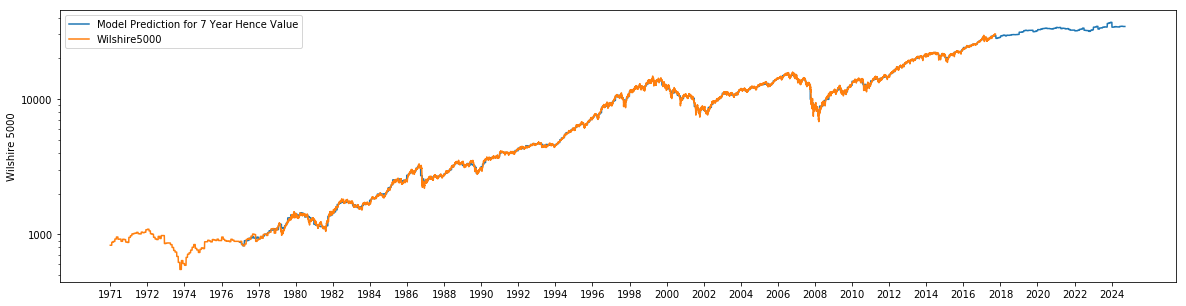

In [114]:
# Find the Train Target

indicesOfTrain=train.index
indicesOfTrainTarget=indicesOfTrain + pd.Timedelta(weeks=7*52)

trainTargetRows=[]
for i in indicesOfTrainTarget:
     trainTargetRows.append(wilshire.loc[i])               

trainTargetRows=pd.DataFrame(trainTargetRows,index=indicesOfTrainTarget)
trainTarget=trainTargetRows['Wilshire5000']   ## Select Target from Rows of Target Dates
trainTarget=pd.DataFrame(trainTarget,index=trainTargetRows.index)

trainTarget=np.ravel(trainTarget,order='c')



# Bagging the MLP Regressor 
bilbo=BaggingRegressor(base_estimator=clf, 
                     n_estimators=20,
                     max_samples=.1,        
                     max_features=.1,      
                     bootstrap=True, 
                     bootstrap_features=False,
                     oob_score=False, 
                     warm_start=False,
                     n_jobs=1, 
                     random_state=None, 
                     verbose=1)


bilbo.fit(train,trainTarget)


## Make Bagged Predictions for both train and test for visualization

graph(clf)


In [147]:
# Optimize: loss 215,000  validation .9962

In [148]:
# Notes:

In [115]:
bilbo.estimators_features_
for i in bilbo.estimators_features_:
    print(wilshire.columns.values[i])

['B766RA3Q086SBEA' 'CEU3200000008' 'LNU03000026' 'DONGRC1Q027SBEA'
 'Y056RL1Q225SBEA' 'WIOBEN' 'ROWFUSQ027S' 'TOTALFC' 'HNOGFIQ027S'
 'IPX5EHTKNQ' 'W988RC1Q027SBEA' 'COMPRNFB' 'IPB52000NQ' 'Y695RG3Q086SBEA'
 'FBOAREQ027S' 'AUTHNOTNET' 'PCU3359293359291' 'FGISTRQ027S' 'LNU02032196'
 'FGDSLAQ027S' 'LNS13000088' 'A766RX1Q020SBEA' 'W146RG3Q086SBEA'
 'HNOLIRQ027S' 'CAPUTLG2122SQ' 'CWSR0000SA0L5' 'NCBTLIQ027S'
 'B467RC1Q027SBEA' 'LNU04000097' 'B687RG3Q086SBEA' 'Y058RC1Q027SBEA'
 'Y806RC1Q027SBEA' 'A064RC1Q027SBEA' 'W791RC1Q027SBEA' 'IPX50001SQ'
 'HNOTMBQ027S' 'B842RA3Q086SBEA' 'IPB51212N' 'WPU11720501'
 'Y050RC1Q027SBEA' 'B798RA3Q086SBEA' 'SLGTLSQ027S' 'W241RA3Q086SBEA'
 'PRS88003102' 'SVSTSL' 'A863RG3Q086SBEA' 'SHCISA156MSFRBPHI'
 'ASSCPAQ027S' 'M1V' 'TCDNS' 'CTODIV' 'NCBFDIUSL' 'MIOBEN' 'VAOTOT'
 'B708RG3Q086SBEA' 'USGSEC' 'REALLNNSA' 'LANC542NAN' 'CUURA103SAA'
 'FLNREVNDI' 'IPB52100N' 'NCBGCFQ027S' 'CES8000000035' 'AB61RA3Q086SBEA'
 'NNBTRTQ027S' 'LNU03026511' 'W118RL1Q225SBEA' 'WYOFAR' '

In [121]:
## Train Random Forest Regressor on the Data to Present to Extract Feature Importances

train=wilshire['1971-1-1':'2011-9-16']  
test=wilshire['2011-9-16':date.today()] 

# Normalize Train and Test Sets using only train means and standard deviations

mean=train.mean(axis=0)
std=train.std(axis=0)

train=(train-mean)/std
test=(test-mean)/std


What is the shape of the train set: (14869, 5664)
What is the shape of the test set: (2555, 5664)
How many NaNs in Train Set? 14869
How many NaNs in Test Set? 14869
What is the shape of the train set: (14869, 5663)
What is the shape of the test set: (2555, 5663)
How many NaNs in Train Set? 0
How many NaNs in Test Set? 0
(14869,)


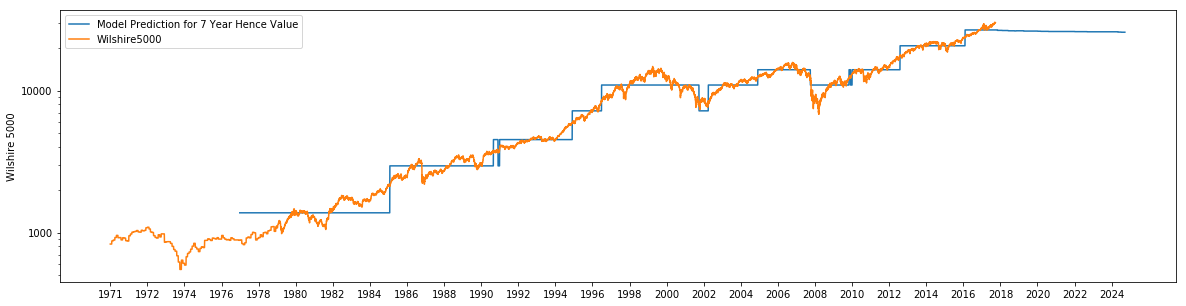

In [122]:
# Random Forest Regressor

# Find the Train Target

indicesOfTrain=train.index
indicesOfTrainTarget=indicesOfTrain + pd.Timedelta(weeks=7*52)

trainTargetRows=[]
for i in indicesOfTrainTarget:
     trainTargetRows.append(wilshire.loc[i])               

trainTargetRows=pd.DataFrame(trainTargetRows,index=indicesOfTrainTarget)
trainTarget=trainTargetRows['Wilshire5000']   ## Select Target from Rows of Target Dates
trainTarget=pd.DataFrame(trainTarget,index=trainTargetRows.index)

trainTarget=np.ravel(trainTarget,order='c')

print(trainTarget.shape)

randy = RandomForestRegressor(bootstrap=False,max_depth=3, random_state=0, n_estimators=100)
randy.fit(train,trainTarget)

graph(randy)

In [123]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(wilshire.columns, randy.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances={}
for k, v in feats.items():
    if v!=0:
        importances[k]=v  
        
sorted_by_value = sorted(importances.items(), key=lambda kv: kv[1])

sorted_by_value

[('WPU0285', 4.265964634117881e-05),
 ('WPU1175', 8.531929268235666e-05),
 ('PCU3351223351221', 0.00010341348730865122),
 ('PCU335313335313P', 0.0001279789390235182),
 ('PCU311412311412', 0.00015512023096301493),
 ('CAPG316S', 0.00020682697461728956),
 ('WPU1173', 0.00020682697461734477),
 ('TVCKSSL', 0.0002100815578759611),
 ('CES5500000010', 0.00021008155787596665),
 ('WPU153', 0.0002100815578759674),
 ('DTRTNM', 0.00021008155787596847),
 ('CES3200000006', 0.0002100815578760208),
 ('CAPX4HTK2S', 0.0002100815578760209),
 ('STDTI', 0.00021008155787603192),
 ('IPB51121S', 0.00021008155787605547),
 ('UNDCONNETNSA', 0.00021008155787609695),
 ('M2OWN', 0.0002100815578760997),
 ('HNFSEPUSSA', 0.00021008155787611857),
 ('CAPB5640CS', 0.00021008155787614807),
 ('STDSL', 0.00021008155787615308),
 ('M2MOWN', 0.00042016311575180266),
 ('UNDCONWTNSA', 0.00042016311575197754),
 ('CES9092200001', 0.0004201631157519995),
 ('CEU9091912001', 0.00042016311575212006),
 ('CES2000000010', 0.00042016311575

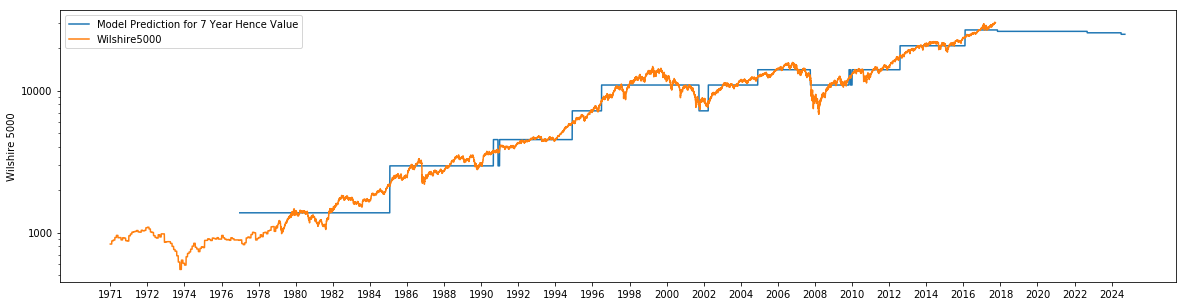

In [119]:
graph(randy)